In [88]:
import pandas as pd
%pylab inline

import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


Load dataset and remove url and extract shares

In [89]:
df=pd.read_csv("OnlineNewsPopularity.csv")
df = df.rename(columns = {
       'url': ' url'  
    })
df.rename(columns=lambda x: x[1:], inplace=True)
y = df.pop('shares')

del df['url']

Visualise dataset and labels

In [116]:
print("Dataframe shape: {0}".format(df.shape))
print("Labels shape: {0}".format(y.shape))
# print(df.columns)

scaler = preprocessing.StandardScaler()
dataset = scaler.fit_transform(df)
# last item uses MinMaxScaler
y = np.array(y).reshape(-1, 1)
scaler = preprocessing.RobustScaler()
labels = scaler.fit_transform(y)

print(dataset[1])
print(labels[:-10])

Dataframe shape: (39644, 59)
Labels shape: (39644, 1)
[ 1.75788035e+00 -6.61656647e-01 -6.18793806e-01  1.60558818e-02
  6.75074836e-04  3.14787095e-02 -6.95709247e-01 -5.94963251e-01
 -4.26525775e-01 -3.04268192e-01  4.32837959e-01 -1.68862599e+00
 -2.36445017e-01 -4.65358733e-01  2.30974702e+00 -2.49487028e-01
 -4.76911337e-01 -5.19566229e-01 -3.74923515e-01 -2.99110670e-01
 -5.03187845e-01 -2.34755267e-01 -3.50734772e+00 -1.91917761e+00
 -9.82156467e-01 -9.27594897e-01 -2.37901396e+00 -2.02587394e-01
 -2.51765856e-01 -2.64412477e-01  2.22523233e+00 -4.78663628e-01
 -4.80454058e-01 -4.73760968e-01 -4.09826850e-01 -2.56820594e-01
 -2.72322187e-01 -3.88118062e-01  2.33925308e+00 -4.15144313e-01
 -5.89153419e-01 -5.88335316e-01 -6.36381377e-01 -8.75228258e-01
  3.05774412e-01  2.01533946e-01 -8.55074318e-02  2.69095982e-01
 -1.36191636e-01 -6.40040044e-01 -8.70967504e-01 -2.28940794e-01
  1.10217358e+00  1.36742366e+00  7.86421309e-02 -8.70806572e-01
 -2.69076177e-01  8.37748634e-01 -6.

In [117]:
np.random.seed(100)
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

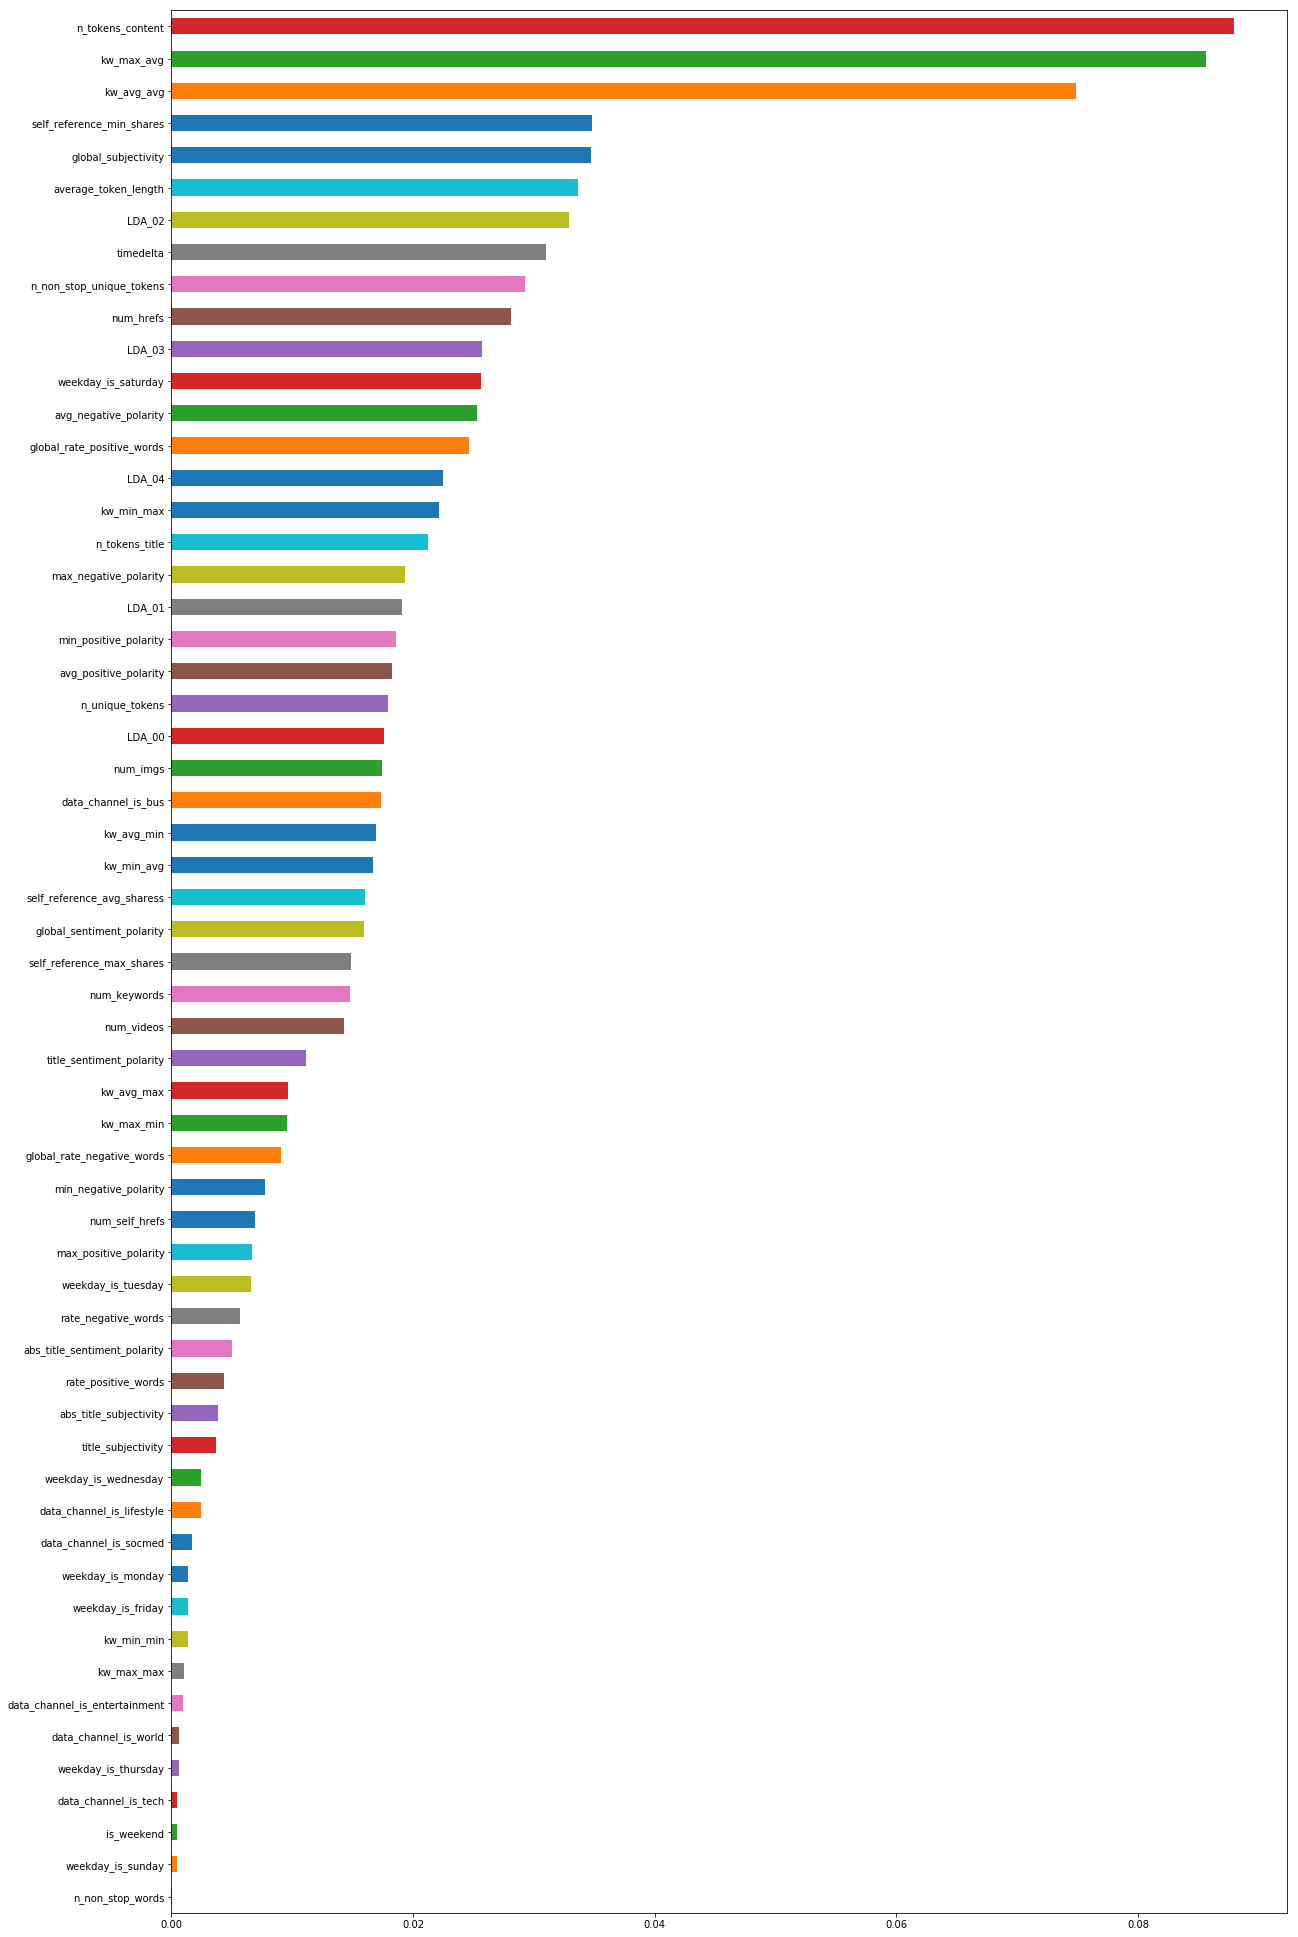

In [112]:
feature_importances = pd.Series(model.feature_importances_, index=df.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(20,35))

Visualise top 30 features

In [113]:
feat_importances = feature_importances.iloc[::-1]
print(feat_importances[:30])

n_tokens_content              0.087967
kw_max_avg                    0.085654
kw_avg_avg                    0.074884
self_reference_min_shares     0.034791
global_subjectivity           0.034730
average_token_length          0.033630
LDA_02                        0.032865
timedelta                     0.031008
n_non_stop_unique_tokens      0.029294
num_hrefs                     0.028073
LDA_03                        0.025667
weekday_is_saturday           0.025581
avg_negative_polarity         0.025274
global_rate_positive_words    0.024621
LDA_04                        0.022479
kw_min_max                    0.022170
n_tokens_title                0.021225
max_negative_polarity         0.019329
LDA_01                        0.019046
min_positive_polarity         0.018582
avg_positive_polarity         0.018236
n_unique_tokens               0.017926
LDA_00                        0.017592
num_imgs                      0.017387
data_channel_is_bus           0.017317
kw_avg_min               

actual max 152.80474649406688
actual min -0.7524271844660194
actual median -0.05393743257820928
predict max 142.8685005393743
predict min -0.3993527508090615
predict median 1.0504045307443364

mse: 31.223242
root_mse: 5.587776
explained_variance_score: -1.278706
mean_absolute_error: 2.353631
median_absolute_error: 1.116343
r2_score: -1.377907


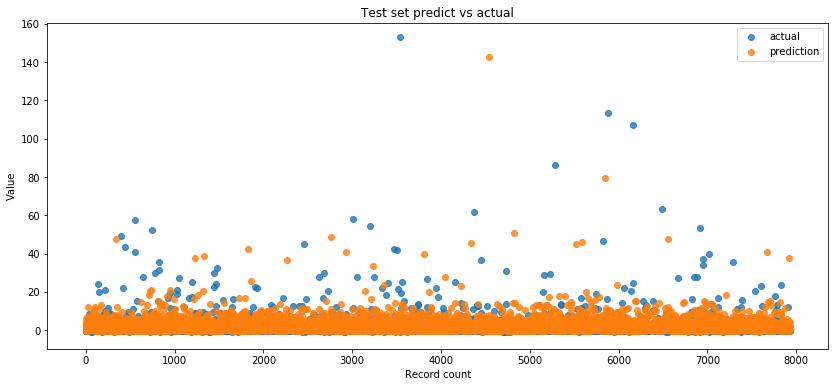

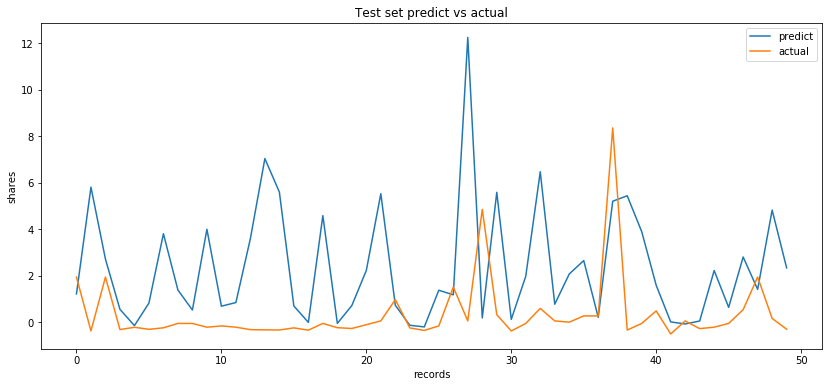

In [118]:
# showing results
score = model.score(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

mse = mean_squared_error(y_pred, y_test)
rmse = math.sqrt(mse)
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
# mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("mse: {0}".format(round(mse, 6)))
print('root_mse: {0}'.format(round(rmse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
# print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('model train vs validation loss')
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['mse', 'val_mse'], loc='upper right')
# plt.show()

y_test = np.array(y_test)

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 20)
plt.scatter(x, [pt for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()